In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

Data collection 

Pre-processing of data.

In [64]:
# Importing Data into dataframe
big_mart_data=pd.read_csv("D:\Jan\Project and Assignments\Big Mart Sales Prediction Regression ML\Train.csv")

In [65]:
# first 5 rows of the dataframe
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [66]:
# number of data points (Observations) & number of Features
big_mart_data.shape

(8523, 12)

In [67]:
# Information about the dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:
    
    - Item_Identifier
    - Item_Fat_Content
    - Item_Type
    - Outlet_Identifier 
    - Outlet_Size             
    - Outlet_Location_Type      
    - Outlet_Type

In [68]:
# Checking for missing values

big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [69]:
# Handling Missing Values

## Filling missing values of Item_weight with mean()

big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(),inplace=True)


In [70]:
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Filling missing values of Item_weight with mode()

Here we can see that Outlet_type and Outlet_size are relateable

so we are taking Outlet_type wise mode of Outlet_size so in order 
to fill that accordingly to Outlet_type

In [71]:
mode_of_outlet_size=big_mart_data.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=(lambda x:x.mode()[0]))

mode_of_outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [72]:
missing_values = big_mart_data['Outlet_Size'].isnull()

In [73]:
big_mart_data['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [80]:
big_mart_data['Outlet_Size'].fillna("Small",inplace=True)

In [54]:
big_mart_data.loc[missing_values,'Outlet_Size'] = big_mart_data.loc[missing_values,'Outlet_Type'].apply(lambda x: mode_of_outlet_size)

In [81]:
big_mart_data['Outlet_Size'].value_counts()

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [52]:
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Data Analysis

In [25]:
# Statistical measures anout the data

big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Numerical Features

In [26]:
sns.set()

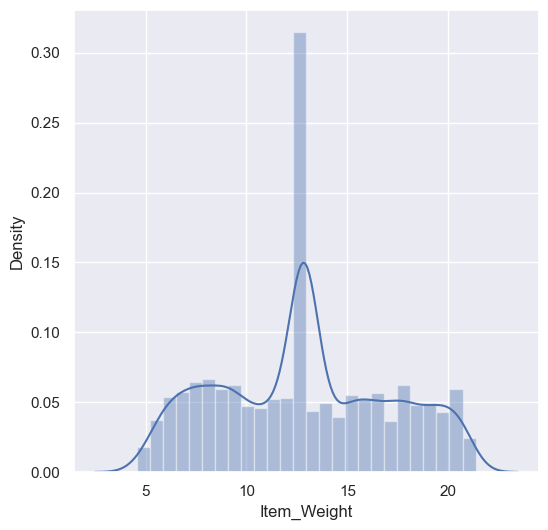

In [28]:
# Item_weight distribution

plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Weight'])
plt.show()

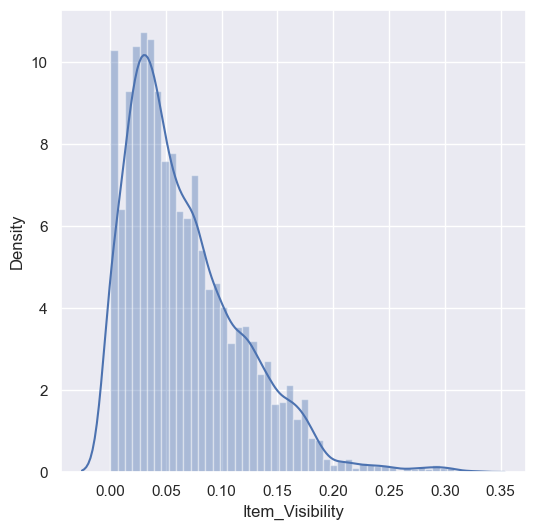

In [29]:
# Item_visibilty distribution

plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Visibility'])
plt.show()

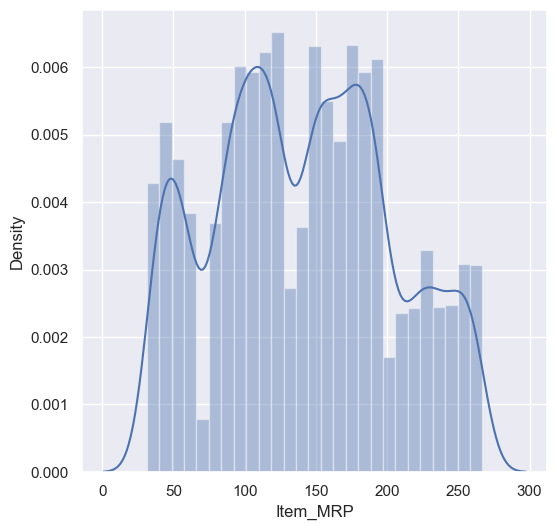

In [30]:
# Item_MRP distribution

plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_MRP'])
plt.show()

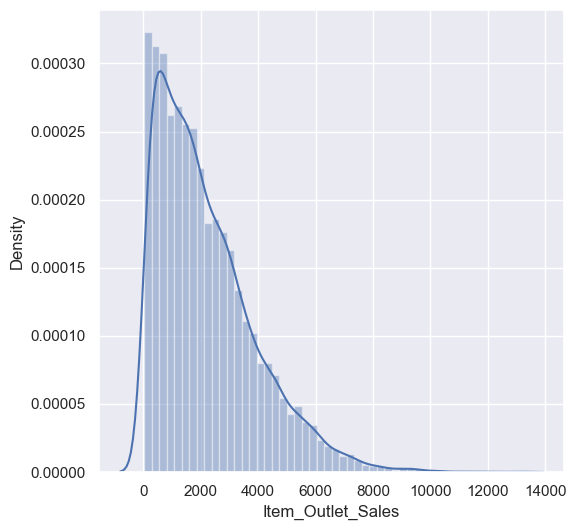

In [34]:
# Item_Outlet_Sales distribution

plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

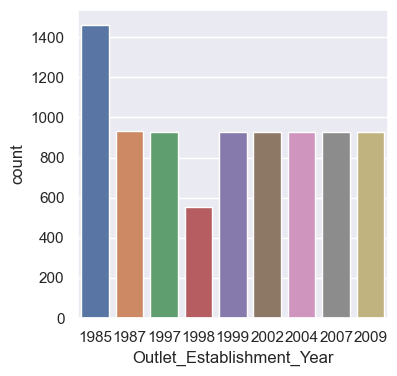

In [32]:
# Outlet_Establishment_Year
plt.figure(figsize=(4,4))
sns.countplot(x='Outlet_Establishment_Year',data=big_mart_data)
plt.show()

Categorical Features

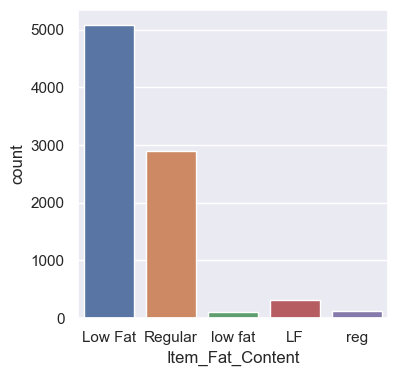

In [35]:
# Item_Fat_Content
plt.figure(figsize=(4,4))
sns.countplot(x='Item_Fat_Content',data=big_mart_data)
plt.show()

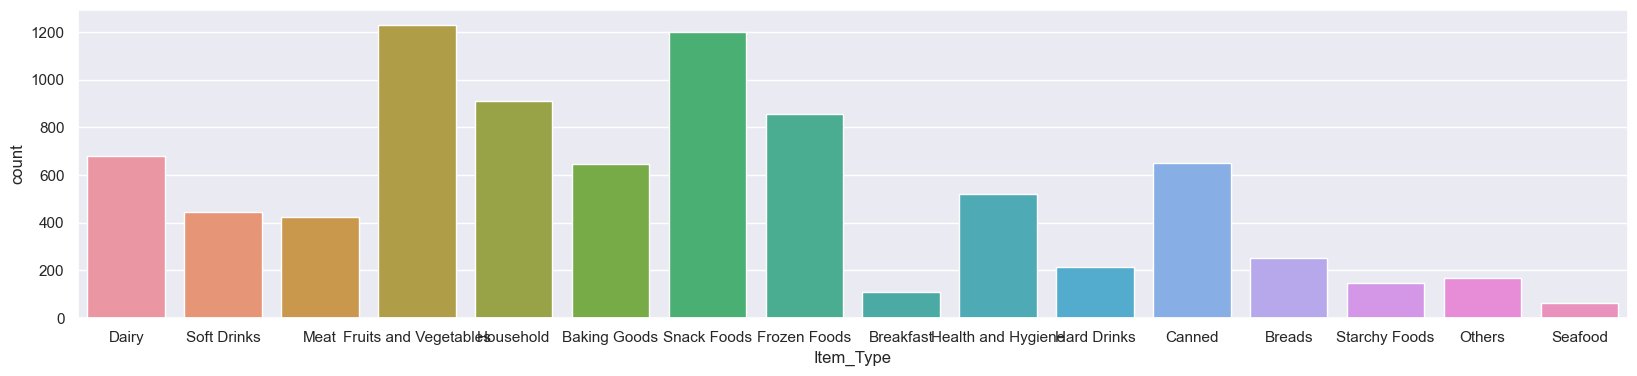

In [42]:
# Item_Type
plt.figure(figsize=(20,4))
sns.countplot(x='Item_Type',data=big_mart_data)
plt.show()

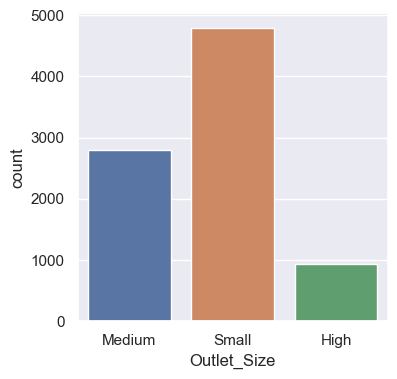

In [83]:
# Outlet_Size
plt.figure(figsize=(4,4))
sns.countplot(x='Outlet_Size',data=big_mart_data)
plt.show()

In [85]:
big_mart_data['Item_Fat_Content'].value_counts()


Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [86]:
big_mart_data.replace({'Item_Fat_Content':{'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}},inplace=True)


In [87]:
big_mart_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Label Encoding:

In [88]:
encoder = LabelEncoder()

In [92]:
big_mart_data.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138


In [93]:
big_mart_data['Item_Identifier']=encoder.fit_transform(big_mart_data['Item_Identifier'])
big_mart_data['Item_Fat_Content']=encoder.fit_transform(big_mart_data['Item_Fat_Content'])
big_mart_data['Item_Type']=encoder.fit_transform(big_mart_data['Item_Type'])
big_mart_data['Outlet_Identifier']=encoder.fit_transform(big_mart_data['Outlet_Identifier'])
big_mart_data['Outlet_Size']=encoder.fit_transform(big_mart_data['Outlet_Size'])
big_mart_data['Outlet_Location_Type']=encoder.fit_transform(big_mart_data['Outlet_Location_Type'])
big_mart_data['Outlet_Type']=encoder.fit_transform(big_mart_data['Outlet_Type'])

In [94]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


Splitting Features and Target

In [95]:
x = big_mart_data.drop('Item_Outlet_Sales',axis=1)
y=big_mart_data['Item_Outlet_Sales']

Splitting data into Training and Testing Data

In [108]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=2)

In [109]:
print(x.shape,x_test.shape,x_train.shape)

(8523, 11) (1705, 11) (6818, 11)


Machine_Learning Model Training

XGBoost Regressor

In [110]:
regressor = XGBRegressor()

In [111]:
regressor.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluation

In [112]:
# Prediction  on training data
training_data_prediction=regressor.predict(x_train)

In [113]:
## R squared value
r2_train = metrics.r2_score(y_train,training_data_prediction)
r2_train

0.8639680373364909

In [114]:
# Prediction  on testing data
testing_data_prediction=regressor.predict(x_test)

In [115]:
## R squared value
r2_test = metrics.r2_score(y_test,testing_data_prediction)
r2_test

0.5233136709735687